# Imports

In [1]:
#General Modules
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim
import torchvision
from matplotlib import pyplot as plt


#Custom Modules
import utils
import paper
import modified_resnet


# Load Model

In [2]:
# Load the modified resnet model with a list of features outputs
net = modified_resnet.resnet101(pretrained = True)
net.train()
net.cuda();

# Test Model

In [3]:
img = torch.rand(1,3,224,500).cuda()

# The model is modified to output classification plus a list of features from various parts in the model
out, features = net(img)

# Print the shape of the features it extracts
for feature in features:
    print(feature.shape)

torch.Size([1, 256, 56, 125])
torch.Size([1, 512, 28, 63])
torch.Size([1, 1024, 14, 32])
torch.Size([1, 2048, 7, 16])


# Load and Resize Image

In [4]:
img_path = "tom1.jpg"

0.499806048869


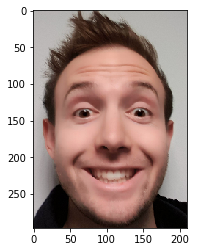

In [5]:
img_np = cv2.imread(img_path)
img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)

#Resize the image to a nominal size so that blurs and effects are proportionate
image_w,image_h = paper.size("A4","portrait")
image_w = int(round(image_w*1000))
image_h = int(round(image_h*1000))
img_np = utils.crop_resize(img_np,image_w,image_h)

average_brightness = np.mean(img_np) / 255 
print(average_brightness)

plt.imshow(img_np);

In [6]:
#convert image to tensor
to_tensor = torchvision.transforms.ToTensor()
img_tensor = to_tensor(img_np).cuda().unsqueeze(dim=0)

#get target features
with torch.no_grad():
    output,target_features = net(img_tensor)


# Define Feature Similarity Loss

In [7]:
class FeatureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,feature_list1, feature_list2, scale_list):
        loss = torch.tensor(0).float().cuda()
        
        
        for feature1, feature2, scale in zip(feature_list1, feature_list2, scale_list):
            loss += scale * self.mse(feature1, feature2)
   
            
        return loss
            


# Run Training Loop to Generate Image

tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


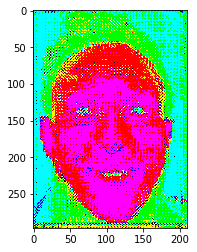

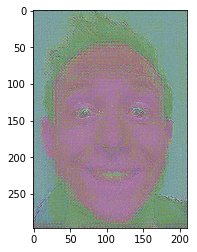

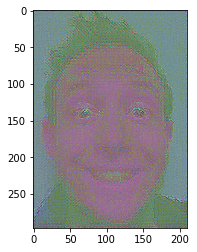

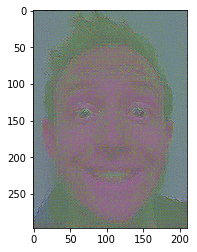

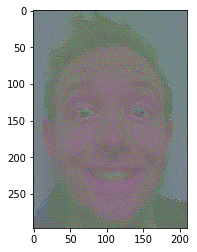

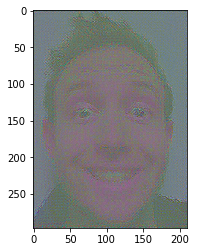

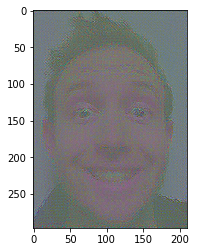

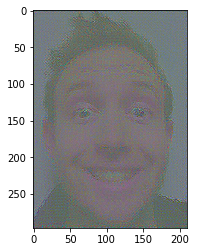

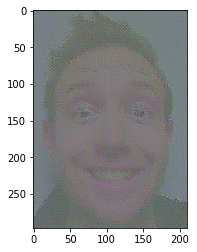

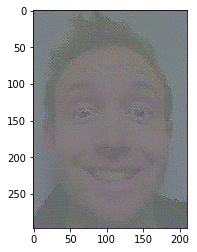

In [10]:


n = 1000
scales = [1.,0.,0.,0.]

canvas = nn.Parameter(torch.ones_like(img_tensor).float()*average_brightness).cuda()
# optimizer = torch.optim.SGD([canvas], lr = 10.0, momentum=0.9)
optimizer = torch.optim.Adam([canvas], lr = 0.1)
criterion = FeatureLoss()

for i in range(n):
    
    optimizer.zero_grad()
    
    output, features = net(canvas)
    
    loss = criterion(features,target_features,scales)
    
    loss.backward()
    
    optimizer.step()

    if i % 100 == 0:
        print(loss)
        canvas_np = canvas.cpu().squeeze(0).detach().numpy().transpose(1,2,0)
        canvas_np -= np.min(canvas_np)
        canvas_np /= np.max(canvas_np)
        plt.figure()
        plt.imshow(canvas_np)
    
